# Brain Tumor Detection: Image Classification Using Deep Learning Techniques

## Visual Geometry Group (VGG) - 16 Model Implimentation

Utilizing the VGG transfer learning model pretrained on ImageNet weights, we incorporate additional layers at the end to construct the artificial neural network (ANN) segment of the program.

The convolutional neural network architecture known as VGG16, or Visual Geometry Group 16, is intended for use in image recognition and classification applications. VGG16, created by the University of Oxford's Visual Geometry Group, is distinguished by its deep architecture, which consists of 16 weight layers—13 convolutional layers and 3 fully connected layers—among them. VGG16 stands out for using tiny 3x3 convolutional filters in every layer.

Usually pre-trained on massive datasets such as ImageNet, VGG16 is frequently used in a variety of computer vision applications as a feature extractor or as a foundation for transfer learning. Practitioners are able to use its learnt features for tasks other than picture classification because of its structure and pre-trained weights.

The dataset is sourced from Kaggle; you can access it by following the provided link.

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

## Importing the Required Libraries

In [1]:
import cv2
import itertools
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

## Setting the path to Dataset

The dataset is divided into two files, "training" and "testing," each of which has pictures from MRI scans of the brain that have been classified as pituitary, glioma, meningioma, and tumors.


The paths to the two folders are designated as "training_set" and "testing_set" variables.

In [2]:
training_set = r'Path\Brain Tumor Detection\Training'
testing_set = r'Path\Brain Tumor Detection\Testing'

## Importing the VGG Model

In order to extract features, a VGG16 model is initialized with its upper classification layers excluded. Pre-trained weights from the ImageNet dataset are used to initialize the model, which is set up to anticipate input photos of size (224, 224, 3). This enables the model to capture important properties for subsequently tailored tasks.

In [3]:
vgg_model = VGG16(include_top = False, input_shape = (224,224,3), weights = 'imagenet')

The VGG model's layers are all rendered untrainable by this code. The VGG model effectively freezes the weights of the layers by iterating through each one and prohibiting updates to the layers during training. The pre-trained layers are utilized as feature extractors in transfer learning, and only the custom layers that are layered on top are trained for the new task.

In [4]:
for layer in vgg_model.layers:
    layer.trainable = False

## Flattening Layer

I utilized a VGG model with the exclusion of its fully connected layers by setting "include_top" to False. Following this, I incorporated two Dense layers as components of an artificial neural network (ANN), concluding with a prediction layer employing the softmax activation function.

In [5]:
flattening_layer = Flatten()(vgg_model.output)

## ANN Architecture

### Dense Layers

Combining flattened layer with dense layers to build the neural network structure.

In [6]:
dense_layer_1 = Dense(256,activation='relu')(flattening_layer)
dense_layer_2 = Dense(128,activation='relu')(dense_layer_1)

In [7]:
pred_layer = Dense(4,activation='softmax')(dense_layer_2)

## Creating Final VGG Model

It creates a new model (VGG) by specifying its inputs and outputs. The inputs are set to the input of the pre-trained VGG model (vgg_model.input), and the output is set to the previously defined Dense layer (pred_layer).

Essentially, it combines the pre-trained VGG model with the additional dense layer to create a new model for the specific task at hand.

In [8]:
VGG_BTD = Model(inputs=vgg_model.input,outputs=pred_layer)
VGG_BTD.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Summary of the Model

In [9]:
VGG_BTD.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Data Augmentation

Utilizing the ImageDataGenerator with different transformation parameters, including rotating, shifting, shearing, zooming, and flipping, is referred to as "data augmentation." In machine learning, data augmentation is frequently used, particularly for computer vision tasks like picture categorization.

By producing variations of the training images, this data generator enhances the model's ability to generalize and strengthens its resistance to orientation changes, shifts, shears, zooms, and flips.

In [10]:
training_image_generator = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

In [11]:
training_images = training_image_generator.flow_from_directory(training_set,
                                                               batch_size = 32,
                                                               shuffle = True,
                                                               target_size = (224,224),
                                                               class_mode = 'categorical')

Found 5712 images belonging to 4 classes.


In [12]:
testing_image_generator = ImageDataGenerator(rescale = 1./255)

In [13]:
testing_images = testing_image_generator.flow_from_directory(testing_set,
                                                          batch_size = 1,
                                                          shuffle = True,
                                                          target_size = (224,224),
                                                          class_mode = 'categorical')

Found 1311 images belonging to 4 classes.


## Early Stop Function

Tracking the validation accuracy that happens during neural network training is done with this callback. If, after a predefined number of consecutive epochs (specified by the patience parameter, which in this case is set to 4), the validation accuracy does not drop below the 0.90 threshold, training will be terminated early to prevent overfitting and conserve computing power.

In [14]:
# The provided code does not include a predefined minimum accuracy level for terminating the training
# Rather, it stops training after detecting three consecutive instances where their no improvement in accuracy

# This stops training if the accuracy remains above 0.90 for three consecutive epochs
class StopTrainingOnLowValidationAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, threshold = 0.90, patience = 4):
        super(StopTrainingOnLowValidationAccuracy, self).__init__()
        self.threshold = threshold
        self.patience = patience
        self.counter = 0

    def on_epoch_end(self, epoch, logs = None):
        if logs['val_accuracy'] is not None and logs['val_accuracy'] > self.threshold:
            self.counter += 1
            if self.counter >= self.patience:
                print("\n")
                print(f"\nStopping training as validation accuracy ({logs['val_accuracy']:.4f}) has been above {self.threshold} for {self.patience} consecutive epochs.")
                self.model.stop_training = True
        else:
            self.counter = 0

custom_callback = StopTrainingOnLowValidationAccuracy(threshold = 0.90, patience = 4)

## Training the Model

The model is trained using a custom callback function on the entire dataset, which consists of 179 batches, over 15 epochs.

In [15]:
VGG_BTD.fit(training_images,
          epochs = 15,
          steps_per_epoch = len(training_images),
          validation_data = testing_images,
          callbacks = [custom_callback])

Epoch 1/15


179/179 [==============================] - 1212s 7s/step - loss: 0.5687 - accuracy: 0.8120 - val_loss: 0.3117 - val_accuracy: 0.8856
Epoch 2/15
179/179 [==============================] - 1269s 7s/step - loss: 0.2131 - accuracy: 0.9205 - val_loss: 0.2419 - val_accuracy: 0.9062
Epoch 3/15
179/179 [==============================] - 1308s 7s/step - loss: 0.1522 - accuracy: 0.9438 - val_loss: 0.1856 - val_accuracy: 0.9268
Epoch 4/15
179/179 [==============================] - 1311s 7s/step - loss: 0.1325 - accuracy: 0.9496 - val_loss: 0.1344 - val_accuracy: 0.9527
Epoch 5/15
179/179 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9660


Stopping training as validation accuracy (0.9580) has been above 0.9 for 4 consecutive epochs.
179/179 [==============================] - 1317s 7s/step - loss: 0.0955 - accuracy: 0.9660 - val_loss: 0.1159 - val_accuracy: 0.9580


## Plotting the Curves

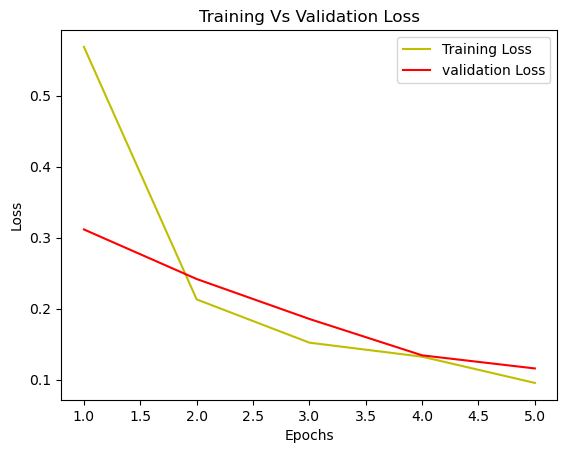

In [16]:
# Training Loss Vs Validation Loss
# I have mentioned two different ways to plot the graphs, please take a look on both
loss = VGG_BTD.history.history['loss']
val_loss = VGG_BTD.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'validation Loss')
plt.title('Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

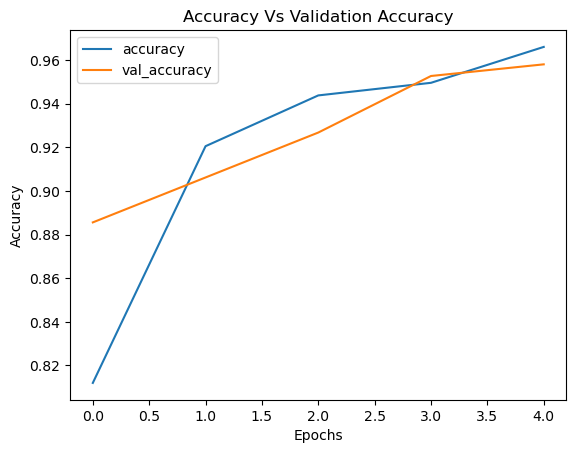

In [17]:
# Accuracy Vs Validation Accuracy
# This is other way of plotting the plot
losses = pd.DataFrame(VGG_BTD.history.history)
losses[['accuracy','val_accuracy']].plot()
plt.title('Accuracy Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evalutation of the Model

In [18]:
predictions = VGG_BTD.predict(testing_images)
print(predictions)

1311/1311 [==============================] - 314s 239ms/step
[[2.9280235e-03 5.7749778e-01 4.1946599e-01 1.0823107e-04]
 [7.1948818e-03 9.9277204e-01 5.5653754e-06 2.7599823e-05]
 [3.1911318e-06 9.5112155e-05 4.2861875e-06 9.9989736e-01]
 ...
 [1.5359374e-06 2.3517443e-05 9.9994469e-01 3.0301886e-05]
 [2.2707644e-03 2.6395551e-03 2.0190284e-05 9.9506950e-01]
 [3.8057991e-07 9.9895799e-01 9.1012498e-06 1.0324277e-03]]


## Confusion Matrix

Found 1311 images belonging to 4 classes.
Total number of samples: 1311


Number of batches: 40
40/40 [==============================] - 212s 5s/step
40 Batches are processed


Number of batches: 41
41/41 [==============================] - 227s 6s/step
41 Batches are processed (Same Batches)


Number of batches: 41
41/41 [==============================] - 227s 6s/step
41 Batches are processed (Same Batches)


True Labels: 1311
Predicted Labels: 1311


First Matrix is Normalized Confusion Matrix

Second Confusion Matrix is Without Normalization


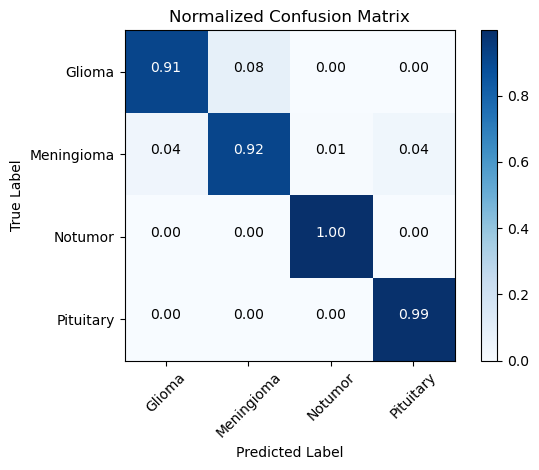

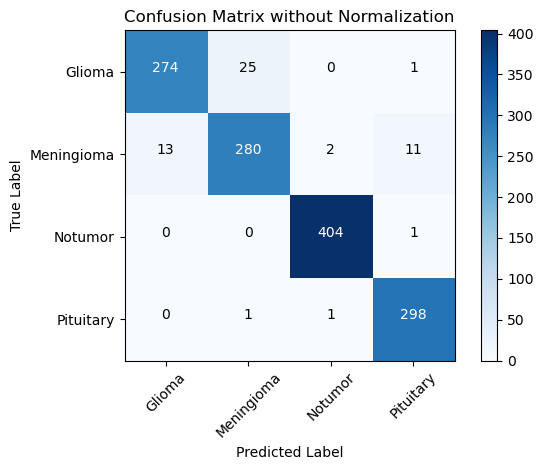

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)  
test_generator = test_datagen.flow_from_directory(
    testing_set,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  
    shuffle = False  
)

true_labels = test_generator.classes
num_samples = len(true_labels)

num_batches = num_samples // test_generator.batch_size
print("Total number of samples:", num_samples)
print("\n")

print("Number of batches:", num_batches)
predictions = VGG_BTD.predict(test_generator, steps = num_batches, verbose = 1)
# When verbose = 1, it will show a progress bar during the prediction
print("40 Batches are processed")
print("\n")
print("Number of batches:", num_batches + 1)
predictions = VGG_BTD.predict(test_generator, steps = num_batches + 1, verbose = 1)
print("41 Batches are processed (Same Batches)")
print("\n")
print("Number of batches:", num_batches + 1)
predictions = VGG_BTD.predict(test_generator, steps = num_samples // test_generator.batch_size + 1, verbose = 1)
predicted_labels = np.argmax(predictions, axis = 1)
print("41 Batches are processed (Same Batches)")
print("\n")

actual_label = len(true_labels)
pred_label = len(predicted_labels) 
print(f"True Labels: {actual_label}\nPredicted Labels: {pred_label}")
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ["Glioma", "Meningioma", "Notumor", "Pituitary"]

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("\n")
        print("First Matrix is Normalized Confusion Matrix\n")
    else:
        print('Second Confusion Matrix is Without Normalization')

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True, title = 'Normalized Confusion Matrix')

plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = False, title = 'Confusion Matrix without Normalization')

plt.show()